In [1]:
import tensorflow.keras as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def preprocess_data(X, Y):
    """
    a function that trains a convolutional neural network to classify the
    CIFAR 10 dataset
    :param X: X is a numpy.ndarray of shape (m, 32, 32, 3) containing the
    CIFAR 10 data, where m is the number of data points
    :param Y: Y is a numpy.ndarray of shape (m,) containing the CIFAR 10
    labels for X
    :return: X_p, Y_p
        X_p is a numpy.ndarray containing the preprocessed X
        Y_p is a numpy.ndarray containing the preprocessed Y
    """
    X_p = K.applications.resnet50.preprocess_input(X)
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [3]:
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()
print((x_train.shape, y_train.shape))
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)
print((x_train.shape, y_train.shape))

((50000, 32, 32, 3), (50000, 1))
((50000, 32, 32, 3), (50000, 10))


In [12]:
input_t = K.Input(shape=(64, 64, 3))
res_model = K.applications.ResNet50(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t)

In [13]:
for layer in res_model.layers:
    layer.trainable = False
    # Check the freezed was done ok
for i, layer in enumerate(res_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_2 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [14]:
to_res = (64, 64)

In [15]:
model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(100, activation='relu'))
model.add(K.layers.Dense(10, activation='softmax'))

In [16]:
check_point = K.callbacks.ModelCheckpoint(filepath="cifar10_resized.h5",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [19]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[check_point])

model.save("cifar10_resized.h5")

Epoch 1/10
1563/1563 [==============================] - 304s 192ms/step - loss: 1.0808 - accuracy: 0.6573 - val_loss: 0.8125 - val_accuracy: 0.7319
Epoch 2/10
1563/1563 [==============================] - 311s 199ms/step - loss: 0.6756 - accuracy: 0.7776 - val_loss: 0.7248 - val_accuracy: 0.7625
Epoch 3/10
1563/1563 [==============================] - 317s 203ms/step - loss: 0.5614 - accuracy: 0.8136 - val_loss: 0.6802 - val_accuracy: 0.7749
Epoch 4/10
1563/1563 [==============================] - 309s 198ms/step - loss: 0.4823 - accuracy: 0.8397 - val_loss: 0.6623 - val_accuracy: 0.7839
Epoch 5/10
1563/1563 [==============================] - 299s 191ms/step - loss: 0.4208 - accuracy: 0.8604 - val_loss: 0.6518 - val_accuracy: 0.7911
Epoch 6/10
1563/1563 [==============================] - 320s 205ms/step - loss: 0.3713 - accuracy: 0.8798 - val_loss: 0.6409 - val_accuracy: 0.7970
Epoch 7/10
1563/1563 [==============================] - 321s 206ms/step - loss: 0.3280 - accuracy: 0.8941 - val_

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 64, 64, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               819300    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 24,408,022
Trainable params: 820,310
Non-trainable params: 23,587,712
_________________________________________________________________


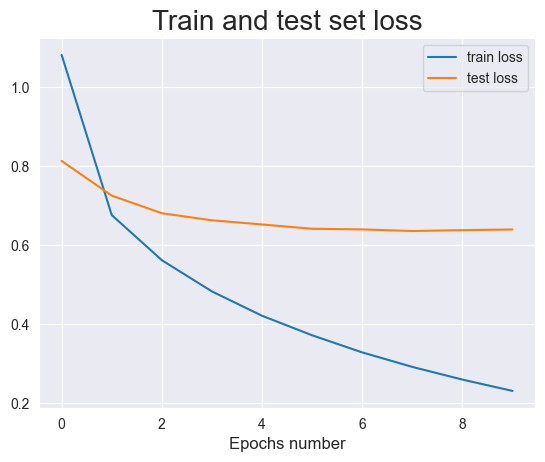

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
model_acc = history.history['accuracy']
model_acc_test = history.history['val_accuracy']

epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='test loss')
plt.title('Train and test set loss', fontsize=20)
plt.xlabel('Epochs number', fontsize=12)
plt.legend()

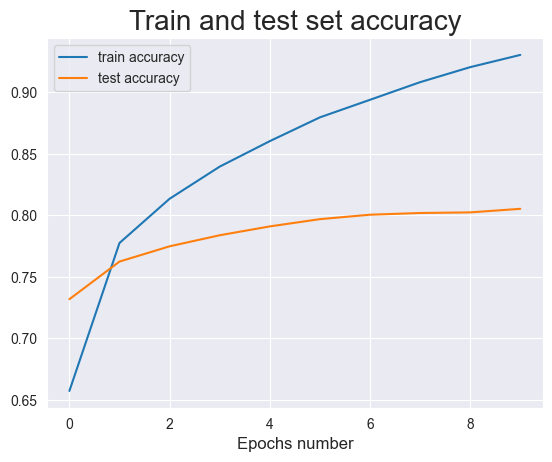

In [22]:
plt.plot(epochs, model_acc, label='train accuracy')
plt.plot(epochs, model_acc_test, label='test accuracy')
plt.title('Train and test set accuracy', fontsize=20)
plt.xlabel('Epochs number', fontsize=12)
plt.legend()